## Example to get predicted submissions file for Kaggle

The following code guides through importing the `train` and `test` csv files, along with basic feature engineering, to get the final predicted sale values.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [69]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [70]:
# combining the train and test dataset, without the 'SalePrice' and 'Id' columns now
# so as to not interfere when separating for X_train, X_test, and y

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [71]:
#train = train[train.GrLivArea < 4000] # for some reason this destroys the accuracy

Looking at the distrbution of the SalePrice, and a ln(x+1) transformation on SalePrice.

- ln(x+1) is used just in case there are any discontinuities or any values at 0, it will not break the code.

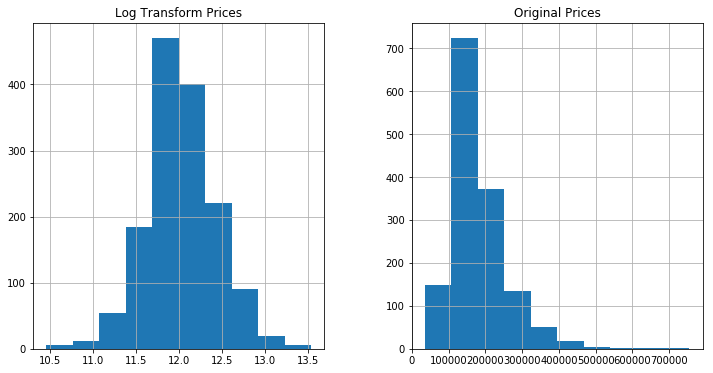

In [72]:
prices = pd.DataFrame({"Original Prices":train["SalePrice"],
                       "Log Transform Prices":np.log1p(train["SalePrice"])})

prices.hist()
plt.show()

As we can see the, the log-transform distribution looks much better than the right-skewed original SalePrice distribution.

In [73]:
print('The skewness value for regular SalePrice is: ' + str(skew(train['SalePrice'])))

The skewness value for regular SalePrice is: 1.880940746034036


In [74]:
# transforming the target variable
train["SalePrice"] = np.log1p(train["SalePrice"])

# the new skewness value
print('The skewness value for the transformed SalePrice is: ' + str(skew(train['SalePrice'])))

The skewness value for the transformed SalePrice is: 0.12122191311528359


The variables make sense to impute with 0, since if the value is missing, it can be assumed that the house does not have that specific feature (i.e. a house without a pool or garage).

In [75]:
all_data.LotFrontage = all_data.LotFrontage.fillna(all_data.LotFrontage.median())
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(all_data.GarageYrBlt.median())

In [76]:
all_data = all_data.fillna(0)

Applying this log transform to all the features that have a skewness value above 0.75:

In [77]:
# taking only numeric continuous features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
#print(skewed_feats.sort_values(ascending=False))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.666326
OpenPorchSF       2.361912
LotFrontage       2.160866
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
Fireplaces        0.648898
BsmtFullBath      0.595454
OverallQual       0.216721
MoSold            0.211835
BedroomAbvGr      0.211572
GarageArea        0.179796
YrSold            0.096170
FullBath          0.036524
GarageCars       -0.342197
YearRemodAdd     -0.503044
YearBuilt        -0.612831
GarageYrBlt      -0.648708
dtype: float64


Transforming any categorical columns with strings into dummy columns (so it is either 0 or 1 depending on what category the observation falls into). 

In [78]:
all_data = pd.get_dummies(all_data, drop_first=True)

In [79]:
print(all_data.shape)

(2919, 268)


Imputing any missing values, of which there are a decent amount:

In [80]:
all_data.isna().sum().sort_values(ascending=False).head(30)

SaleCondition_Partial    0
Condition1_Norm          0
BldgType_2fmCon          0
Condition2_RRNn          0
Condition2_RRAn          0
Condition2_RRAe          0
Condition2_PosN          0
Condition2_PosA          0
Condition2_Norm          0
Condition2_Feedr         0
Condition1_RRNn          0
Condition1_RRNe          0
Condition1_RRAn          0
Condition1_RRAe          0
Condition1_PosN          0
Condition1_PosA          0
Condition1_Feedr         0
BldgType_Twnhs           0
Neighborhood_Veenker     0
Neighborhood_Timber      0
Neighborhood_StoneBr     0
Neighborhood_Somerst     0
Neighborhood_SawyerW     0
Neighborhood_Sawyer      0
Neighborhood_SWISU       0
Neighborhood_OldTown     0
Neighborhood_NridgHt     0
Neighborhood_NoRidge     0
Neighborhood_NWAmes      0
Neighborhood_NPkVill     0
dtype: int64

Since it doesn't make sense to impute the `LotFrontage` with a value of 0, we can either impute it with the mean or median of that column. Or use KNN (probably the best solution). 

Doing the safe route for now, by imputing the missing values with the median of the column.

In [68]:
num_feats = all_data.dtypes[all_data.dtypes != 'object'].index
all_data[num_feats].isna().sum().sort_values(ascending=False).head(10)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
dtype: int64

Setting the `X_train`, `X_test`, and `y` variables for use with the Lasso Regularization model in sklearn. 

In [81]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [44]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

# Defining a RMSE function to calculate the residual mean squared error to evaluate the model
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

The `alpha_vals` grid is set rather lazily, but through basic iteration, any lower and the model simply won't converge, or have a higher RMSE.

In [94]:
alpha_vals = np.logspace(-4, 4, 1000)
#alpha_vals = [1, 0.1, 0.001, 0.0005]
model_lasso = LassoCV(alphas = alpha_vals, normalize=True).fit(X_train, y) 
print("Best alpha value: " + str(model_lasso.alpha_))
model_lasso.score(X_train, y)

Best alpha value: 0.00011377741332214914


0.9251423114391033

In [95]:
print("With 5-fold CV, the RMSE values are: " + str(rmse_cv(model_lasso, X_train, y)))
print("Average RMSE: " + str(rmse_cv(model_lasso, X_train, y).mean()))

With 5-fold CV, the RMSE values are: [0.10243    0.13288816 0.13626522 0.11244549 0.14560481]
Average RMSE: 0.12592673694633943


Since lasso regularization works by shrinking the beta coefficients down to potentially zero, the following cells examine how many coefficients were reduced to zero (eliminated features), and of those that were kept, which ones were the most important.

In [96]:
beta_vals = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Variables kept: " + str(sum(beta_vals != 0)))
print("Variables eliminated: " + str(sum(beta_vals == 0)))

Variables kept: 95
Variables eliminated: 173


In [113]:
list(zip(X_train.columns, beta_vals))

[('MSSubClass', -0.0037233861918521466),
 ('LotFrontage', 0.0),
 ('LotArea', 0.07399422042111611),
 ('OverallQual', 0.05375352938995031),
 ('OverallCond', 0.0340788156873377),
 ('YearBuilt', 0.0017260582953689619),
 ('YearRemodAdd', 0.0008509919155057037),
 ('MasVnrArea', 0.0),
 ('BsmtFinSF1', 0.008041229466913215),
 ('BsmtFinSF2', -0.0),
 ('BsmtUnfSF', -0.0),
 ('TotalBsmtSF', 0.012984409434302076),
 ('1stFlrSF', 0.07252771632256963),
 ('2ndFlrSF', -0.0),
 ('LowQualFinSF', -0.0),
 ('GrLivArea', 0.37757069128011905),
 ('BsmtFullBath', 0.027128239479930743),
 ('BsmtHalfBath', 0.0),
 ('FullBath', 0.012490936216826308),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', -0.0),
 ('KitchenAbvGr', -0.131958309207754),
 ('TotRmsAbvGrd', 0.0),
 ('Fireplaces', 0.018499654087905305),
 ('GarageYrBlt', 0.0),
 ('GarageCars', 0.04965448065780964),
 ('GarageArea', 2.32886466146072e-05),
 ('WoodDeckSF', 0.0026606808376504368),
 ('OpenPorchSF', 0.0005793341625299819),
 ('EnclosedPorch', 0.0),
 ('3SsnPorch', 0.0),
 (

In [108]:
print(beta_vals.sort_values().head(10))
print(beta_vals.sort_values().tail(10))

Condition2_PosN        -0.455899
MSZoning_C (all)       -0.336732
PoolQC_Gd              -0.223822
Functional_Sev         -0.192080
Functional_Maj2        -0.152639
KitchenAbvGr           -0.131958
Exterior1st_BrkComm    -0.104230
Heating_Grav           -0.095241
LotShape_IR3           -0.053026
Neighborhood_Edwards   -0.048996
dtype: float64
SaleType_New            0.062702
GarageQual_Ex           0.063842
Neighborhood_NridgHt    0.071668
1stFlrSF                0.072528
LotArea                 0.073994
Neighborhood_NoRidge    0.083307
RoofMatl_WdShngl        0.091580
Neighborhood_Crawfor    0.098963
Neighborhood_StoneBr    0.100891
GrLivArea               0.377571
dtype: float64


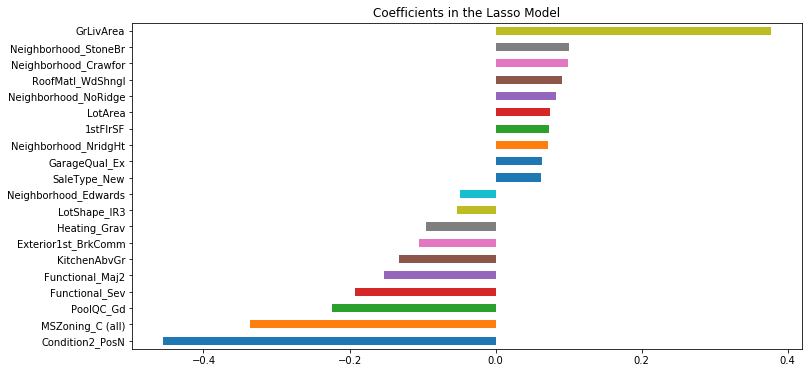

In [109]:
important_feat = pd.concat([beta_vals.sort_values().head(10), beta_vals.sort_values().tail(10)])

important_feat.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

This last cell generated the predictions, and then creates the csv file for Kaggle submission.

As a sidenote, since we performed a log transformation of `np.log1p` on the Sale Price in the beginning, we must do `np.expm1` on the predicted prices to bring it back to the original scale.

In [110]:
pred = np.expm1(model_lasso.predict(X_test))

submission = pd.DataFrame({'Id': test.Id, 'SalePrice': pred})
submission.to_csv('attempt2.csv', index=False)

In [124]:
ridge_var = X_train[(beta_vals!=0).index[beta_vals!=0]]

ridge_var.shape

(1460, 95)

In [140]:
alphas_ridge = np.logspace(-2, 2, 100)

model_ridge = RidgeCV(alphas=alphas_ridge, normalize=True).fit(ridge_var, y)
print("Best alpha value: " + str(model_ridge.alpha_))
model_ridge.score(ridge_var, y)

Best alpha value: 0.13530477745798075


0.9284434994813685

In [134]:
ridge_pred = np.expm1(model_ridge.predict(X_test[(beta_vals!=0).index[beta_vals!=0]]))

submission = pd.DataFrame({'Id': test.Id, 'SalePrice': pred})
submission.to_csv('attempt_ridge2.csv', index=False)

In [136]:
ridge_beta_vals = pd.Series(model_ridge.coef_, index = ridge_var.columns)

In [138]:
ridge_beta_vals.sort_values().head(10)

Condition2_PosN       -0.478761
MSZoning_C (all)      -0.383226
PoolQC_Gd             -0.239724
Functional_Sev        -0.237543
Functional_Maj2       -0.221959
Exterior1st_BrkComm   -0.209326
Heating_Grav          -0.141706
MiscFeature_Othr      -0.126165
KitchenAbvGr          -0.102829
Utilities_NoSeWa      -0.094380
dtype: float64

In [139]:
ridge_beta_vals.sort_values().tail(10)

Utilities_AllPub        0.094380
GarageQual_Ex           0.099240
Heating_GasW            0.104821
Neighborhood_Crawfor    0.116330
Neighborhood_NoRidge    0.118768
Neighborhood_StoneBr    0.122498
RoofMatl_WdShngl        0.151332
Condition2_PosA         0.191835
PoolQC_Ex               0.194094
GrLivArea               0.282952
dtype: float64